# DCGAN PYTORCH IMPLEMENTATION
Forked from here: https://github.com/pytorch/examples

In [152]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable

from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

In [153]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    npimg = npimg-np.amin(npimg)
    npimg = npimg/np.amax(npimg)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis("off")
        
    plt.show()

In [154]:
# We will save the results here
outf="./my_results"

In [155]:
#manualSeed = random.randint(1, 10000)
manualSeed = 4532
print("Random Seed: ", manualSeed)
random.seed(manualSeed)

torch.manual_seed(manualSeed)
cudnn.benchmark = True

use_cuda=True
if use_cuda:
    torch.cuda.manual_seed_all(manualSeed)

if torch.cuda.is_available() and not use_cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

Random Seed:  4532


You will need to download an image dataset and put them into a folder.
The "flowers" dataset, for example, can be found here:
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Usually you need at least a few thousand images to get reasonable results
    

In [156]:
imageSize = 64 # square images for now!
dataroot = "./flowers"
#dataroot = "./resized_imgs"

# folder dataset
dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Scale(imageSize),
                                   transforms.CenterCrop(imageSize),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))


In [157]:
batchSize= 32
workers = 2
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=True, num_workers=int(workers))

In [158]:
print('num of batches:', dataloader.__len__())
print('num Of Images:', dataloader.__len__()*batchSize)

num of batches: 258
num Of Images: 8256


In [159]:
# this example demonstrates how we can load a new batch of data
dataiter = iter(dataloader)
data= dataiter.next()
data[0]=(data[0]+1)/2
print(len(data))
print(data[0].size(),data[1].size())

2
torch.Size([32, 3, 64, 64]) torch.Size([32])


In [160]:
#labels are in data[1][:]
data[1][0:5]


 0
 0
 0
 0
 0
[torch.LongTensor of size 5]

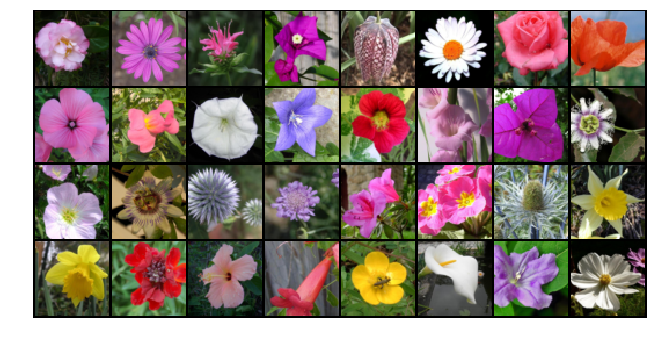

In [161]:
# show some examples from the original data
# images are in data[0][:]
show(make_grid(data[0]))


In [162]:
ngpu = int(1) # use one GPU
nz = int(100) # code dimension (This is the() random noise) input dimension of the generator network)
ngf = int(64) # output dimension of the generator network
ndf = int(64) # input dim (image size) for the discriminator net
nc = 3 # number of input channels (e.g. 3 for RGB channels)

In [163]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [164]:
# Let us create the Generator network
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [165]:
netG = _netG(ngpu)
netG.apply(weights_init)

# if we want to load a saved netG, we can do it here:
#savednetG=outf+"/netG_epoch_39.pth"
#netG.load_state_dict(torch.load(savednetG))
print(netG)


_netG(
  (main): Sequential(
    (0): ConvTranspose2d (100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d (128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d (64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [166]:
# Let us create the Discriminator network
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [167]:
netD = _netD(ngpu)
netD.apply(weights_init)

# If we want to load a saved netD, we can do it here:
#savednetD=outf+"/netD_epoch_39.pth"
#netD.load_state_dict(torch.load(savednetD))
print(netD)


_netD(
  (main): Sequential(
    (0): Conv2d (3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(0.2, inplace)
    (2): Conv2d (64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU(0.2, inplace)
    (5): Conv2d (128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU(0.2, inplace)
    (8): Conv2d (256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU(0.2, inplace)
    (11): Conv2d (512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [168]:
# Binary Cross Entropy between the target (p, 1-p) and the output (q,1-q) distributions
criterion = nn.BCELoss()

In [169]:
input = torch.FloatTensor(batchSize, 3, imageSize, imageSize) # this will be the input of the Discriminator network

noise = torch.FloatTensor(batchSize, nz, 1, 1) # this will be the input of the Generator network

# We will also use some "fixed" noise to monitor the progess of the generated data
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)

label = torch.FloatTensor(batchSize)


In [170]:
real_label = 1
fake_label = 0

In [171]:
# put NetD, netG, the criterion, input, and noise to the GPUs
if use_cuda:
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

In [172]:
fixed_noise = Variable(fixed_noise)

In [173]:
# setup optimizer

beta1 =0.5
lr=0.0002

optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

#optimizerD = optim.SGD(netD.parameters(), lr=0.001, momentum=0.9)
#optimizerG = optim.SGD(netG.parameters(), lr=0.001, momentum=0.9)

## We will show one step of how to optimize NetG and NetD
Then we will put these steps into a loop

In [174]:
############################
# (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
###########################
# train with real
netD.zero_grad()
real_cpu, _ = data # data[0] = images, data[1] =labels (triangle, ellipse, rectangle). Labels are not important
batch_size = real_cpu.size(0)
if use_cuda:
    real_cpu = real_cpu.cuda() # move the image data to the GPUs
input.resize_as_(real_cpu).copy_(real_cpu) #copy the image data to input variable
print("input:", input.size())
label.resize_(batch_size).fill_(real_label) #since this is all real data add them "real_label" label
inputv = Variable(input)
labelv = Variable(label)

input: torch.Size([32, 3, 64, 64])


In [175]:
output = netD(inputv) # caclulate the predicitions of netD network:
output.size()       

torch.Size([32])

In [176]:
print(output[0:5], labelv[0:5]) # We want the predicited output to be all ones (real data)

Variable containing:
 0.6168
 0.6745
 0.1440
 0.8130
 0.3902
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [177]:
# We want the output of netD(real images) to be all ones.
# Let us caclulate the error
errD_real = criterion(output, labelv)
# We want the error to be as small as possible
print("Error of Discriminator on real data: ",errD_real)

Error of Discriminator on real data:  Variable containing:
 0.8524
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [178]:

#Let D_x be the mean of the outputs on real data. 
#Since we used real data, we want D_x to be close to 1
D_x = output.data.mean()
print(D_x)

0.517038881779


In [179]:
# Let us caculate the gradient of errD_real. 
errD_real.backward()

In [180]:
# Now we will train with fake data
noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
noisev = Variable(noise)

In [181]:
#  Generate fake images from noise
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

In [182]:
# add "fake_label" labels to the fake images
labelv = Variable(label.fill_(fake_label))
labelv.size()

torch.Size([32])

In [183]:
output = netD(fake.detach())
output.size()

torch.Size([32])

In [184]:
#We want the output of netD(fake images) to be all zeros
print(output[0:5], labelv[0:5])

Variable containing:
 0.1733
 0.4051
 0.5676
 0.2570
 0.7147
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 0
 0
 0
 0
 0
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [185]:
# Calculate the error of the Discriminiator network on the fake data
errD_fake = criterion(output, labelv)
errD_fake
# We want this error to be as small as possible

Variable containing:
 0.6839
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [186]:
# Calculate the gradient of errD_fake
errD_fake.backward()

In [187]:
#Let D_G_z1 be the mean of the output of the Discriminator on fake data
# We want D_G_z1 to be close to 0
D_G_z1 = output.data.mean()
D_G_z1

0.4616766571998596

In [188]:
# The combined error:
errD = errD_real + errD_fake
errD
# We want this to be as close to zero as possible

Variable containing:
 1.5362
[torch.cuda.FloatTensor of size 1 (GPU 0)]

 Update D network: maximize log(D(x)) + log(1 - D(G(z))) 
 We want D to be as good as possible

In [189]:
optimizerD.step()


## (2) Update G network: maximize log(D(G(z)))

In [190]:
netG.zero_grad()

In [191]:
# The Generator wants to trick the Discriminator
labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
labelv.size()

torch.Size([32])

In [192]:
output = netD(fake)
output.size()

torch.Size([32])

In [193]:
print(output[0:5], labelv[0:5]) #We want the generator the trick the Discriminator, i.e. produce all ones here!

Variable containing:
1.00000e-03 *
  9.1958
  2.4444
  0.9756
  2.8469
  1.5986
[torch.cuda.FloatTensor of size 5 (GPU 0)]
 Variable containing:
 1
 1
 1
 1
 1
[torch.cuda.FloatTensor of size 5 (GPU 0)]



In [194]:
# We want this to be as small as possible
errG = criterion(output, labelv)
errG

Variable containing:
 5.5677
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [195]:
errG.backward()

In [196]:
# We want this to be as close to one as possible (we want good fake data)
D_G_z2 = output.data.mean()
D_G_z2

0.004576826002448797

In [197]:
optimizerG.step()

Evalutation to see if netG optimizer helped

In [198]:
new_output = netD(netG(noisev))
# we want these to be all ones
new_errG = criterion(new_output, labelv)
# We want the error to be as small as possible
new_errG

Variable containing:
1.00000e-03 *
  8.3798
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [199]:
# We want this to be as close to one as possible (we want good fake data)
new_D_G_z2 = new_output.data.mean()
new_D_G_z2

0.9916792511940002

In [200]:
# we want these to be all ones
#print(new_output, labelv)

In [201]:
niter = 35
epoch=1
i=1
print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))

[1/35][1/258] Loss_D: 1.5362 Loss_G: 5.5677 D(x): 0.5170 D(G(z)): 0.4617 / 0.0046


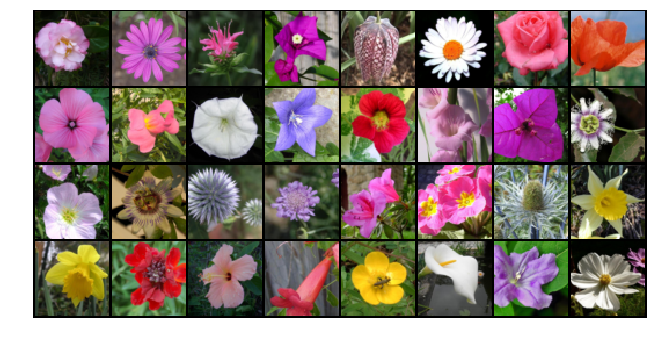

In [202]:
show(make_grid(real_cpu.cpu())) #show some real data

In [203]:
fake = netG(fixed_noise)
fake.data.size()

torch.Size([32, 3, 64, 64])

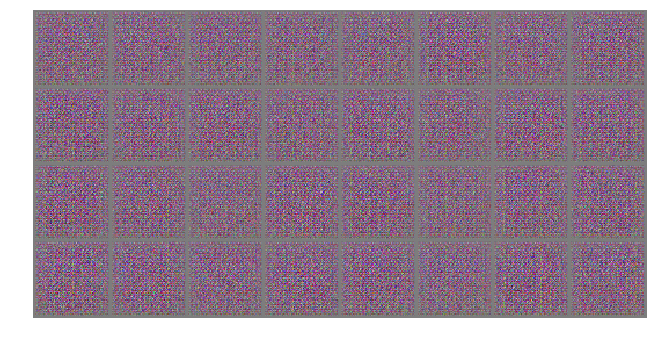

In [204]:
show(make_grid(fake.data.cpu())) # show some fake data. It should look bad for an untrained model

The below loop might take a while

In [205]:
use_cuda=True
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if use_cuda:
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader),
                     errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        
        

        if i % 100 == 0:
            vutils.save_image(real_cpu,'%s/real_samples.png' % outf,normalize=True)
            fake = netG(fixed_noise)
            #show(make_grid(fake.data.cpu()))
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)


[0/35][0/258] Loss_D: 1.2180 Loss_G: 6.5663 D(x): 0.7702 D(G(z)): 0.5410 / 0.0018
[0/35][50/258] Loss_D: 0.0509 Loss_G: 6.5224 D(x): 0.9606 D(G(z)): 0.0079 / 0.0025
[0/35][100/258] Loss_D: 0.3683 Loss_G: 7.5442 D(x): 0.9278 D(G(z)): 0.2188 / 0.0008
[0/35][150/258] Loss_D: 0.1539 Loss_G: 6.6253 D(x): 0.9018 D(G(z)): 0.0099 / 0.0026
[0/35][200/258] Loss_D: 0.4970 Loss_G: 5.2311 D(x): 0.8874 D(G(z)): 0.2713 / 0.0076
[0/35][250/258] Loss_D: 0.4453 Loss_G: 8.2238 D(x): 0.9521 D(G(z)): 0.3008 / 0.0004
[1/35][0/258] Loss_D: 0.1241 Loss_G: 7.1527 D(x): 0.9140 D(G(z)): 0.0237 / 0.0012
[1/35][50/258] Loss_D: 4.7885 Loss_G: 5.9449 D(x): 0.1240 D(G(z)): 0.0002 / 0.0106
[1/35][100/258] Loss_D: 0.7124 Loss_G: 6.7529 D(x): 0.6179 D(G(z)): 0.0036 / 0.0028
[1/35][150/258] Loss_D: 1.5883 Loss_G: 0.4294 D(x): 0.3035 D(G(z)): 0.0283 / 0.7184
[1/35][200/258] Loss_D: 0.4796 Loss_G: 4.5576 D(x): 0.9463 D(G(z)): 0.3178 / 0.0140
[1/35][250/258] Loss_D: 0.3575 Loss_G: 3.8483 D(x): 0.8395 D(G(z)): 0.1349 / 0.033

[16/35][100/258] Loss_D: 0.9196 Loss_G: 2.1836 D(x): 0.5342 D(G(z)): 0.1580 / 0.1484
[16/35][150/258] Loss_D: 0.7175 Loss_G: 3.6235 D(x): 0.8364 D(G(z)): 0.3810 / 0.0352
[16/35][200/258] Loss_D: 0.3814 Loss_G: 3.1701 D(x): 0.8025 D(G(z)): 0.1188 / 0.0614
[16/35][250/258] Loss_D: 0.9182 Loss_G: 4.7217 D(x): 0.9796 D(G(z)): 0.5299 / 0.0138
[17/35][0/258] Loss_D: 0.9917 Loss_G: 3.5904 D(x): 0.7314 D(G(z)): 0.3912 / 0.0453
[17/35][50/258] Loss_D: 0.5064 Loss_G: 4.2284 D(x): 0.9398 D(G(z)): 0.3233 / 0.0187
[17/35][100/258] Loss_D: 0.3749 Loss_G: 2.8386 D(x): 0.8040 D(G(z)): 0.1102 / 0.0734
[17/35][150/258] Loss_D: 0.7374 Loss_G: 2.5253 D(x): 0.6010 D(G(z)): 0.0552 / 0.1103
[17/35][200/258] Loss_D: 0.5094 Loss_G: 1.7932 D(x): 0.7189 D(G(z)): 0.1134 / 0.2022
[17/35][250/258] Loss_D: 0.5456 Loss_G: 2.3263 D(x): 0.7052 D(G(z)): 0.1073 / 0.1384
[18/35][0/258] Loss_D: 0.5157 Loss_G: 2.3270 D(x): 0.7681 D(G(z)): 0.1674 / 0.1228
[18/35][50/258] Loss_D: 0.7331 Loss_G: 3.4254 D(x): 0.7624 D(G(z)): 0.

[32/35][150/258] Loss_D: 0.1965 Loss_G: 4.8292 D(x): 0.8693 D(G(z)): 0.0379 / 0.0146
[32/35][200/258] Loss_D: 0.3316 Loss_G: 3.7906 D(x): 0.8403 D(G(z)): 0.1153 / 0.0347
[32/35][250/258] Loss_D: 0.3983 Loss_G: 4.1944 D(x): 0.9534 D(G(z)): 0.2477 / 0.0192
[33/35][0/258] Loss_D: 0.3654 Loss_G: 3.0512 D(x): 0.7953 D(G(z)): 0.0808 / 0.0654
[33/35][50/258] Loss_D: 0.4887 Loss_G: 4.7598 D(x): 0.9495 D(G(z)): 0.3251 / 0.0105
[33/35][100/258] Loss_D: 0.3197 Loss_G: 4.3028 D(x): 0.9250 D(G(z)): 0.1817 / 0.0180
[33/35][150/258] Loss_D: 0.8038 Loss_G: 5.6674 D(x): 0.9447 D(G(z)): 0.4346 / 0.0070
[33/35][200/258] Loss_D: 0.4923 Loss_G: 2.3372 D(x): 0.7186 D(G(z)): 0.0707 / 0.1381
[33/35][250/258] Loss_D: 1.0107 Loss_G: 6.4429 D(x): 0.9853 D(G(z)): 0.5393 / 0.0039
[34/35][0/258] Loss_D: 0.6276 Loss_G: 5.3875 D(x): 0.9722 D(G(z)): 0.4034 / 0.0071
[34/35][50/258] Loss_D: 0.4252 Loss_G: 2.2851 D(x): 0.7452 D(G(z)): 0.0891 / 0.1296
[34/35][100/258] Loss_D: 0.2323 Loss_G: 3.7940 D(x): 0.9053 D(G(z)): 0.

In [206]:
# do checkpointing
torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

## Generate new images

In [207]:
noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
noise = noise.cuda()
noisev = Variable(noise)
fake = netG(noisev)
fake.size()

torch.Size([32, 3, 64, 64])

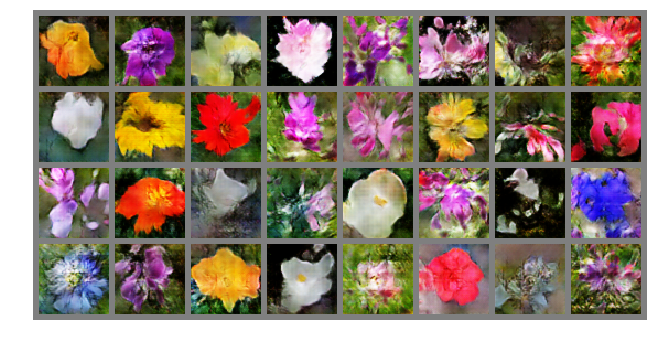

In [208]:
fake=fake.cpu()
show(make_grid(fake.data, padding=5))